<a href="https://colab.research.google.com/github/linkjavier/disco/blob/felipe/models/lstm_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From book: Generative AI with Python and TensorFlow 2 By Joseph Babcock and Raghav Bali

LSTM-Attention Model for Music Generation

In [54]:
import os
import pickle
import numpy as np
from music21 import note, chord, corpus, converter, stream, instrument
import glob
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax
import tensorflow.keras.backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [90]:
!unzip '/content/drive/MyDrive/little_ds_testing_5.zip'

Archive:  /content/drive/MyDrive/little_ds_testing_5.zip
   creating: little_ds_testing_5/
  inflating: little_ds_testing_5/alb_esp1.mid  
  inflating: little_ds_testing_5/alb_esp2.mid  
  inflating: little_ds_testing_5/alb_esp3.mid  
  inflating: little_ds_testing_5/alb_esp4.mid  
  inflating: little_ds_testing_5/alb_esp5.mid  


In [92]:
data_dir = 'little_ds_testing_5'

# list of files
midi_list = os.listdir(data_dir)

# Load and make list of stream objects
original_scores = []
for midi in tqdm(midi_list):
    score = converter.parse(os.path.join(data_dir,midi))
    original_scores.append(score)

print("original_scores", original_scores)

  0%|          | 0/5 [00:00<?, ?it/s]

original_scores [<music21.stream.Score 0x7fc4dd314210>, <music21.stream.Score 0x7fc4e3509450>, <music21.stream.Score 0x7fc4e3b30690>, <music21.stream.Score 0x7fc4e15e1290>, <music21.stream.Score 0x7fc4e762d610>]


In [93]:
# Merge notes into chords
original_scores = [midi.chordify() for midi in tqdm(original_scores)]
print("original_scores", original_scores)

  0%|          | 0/5 [00:00<?, ?it/s]

original_scores [<music21.stream.Part 0x7fc4e6f2d490>, <music21.stream.Part 0x7fc4e7a28550>, <music21.stream.Part 0x7fc4e7a19750>, <music21.stream.Part 0x7fc4eb3e0a90>, <music21.stream.Part 0x7fc4ec324710>]


In [95]:
# Define empty lists of lists
original_chords = [[] for _ in original_scores]
original_durations = [[] for _ in original_scores]
original_keys = []

# Extract notes, chords, durations, and keys
for i, midi in tqdm(enumerate(original_scores)):
    original_keys.append(str(midi.analyze('key')))
    for element in midi:
        if isinstance(element, note.Note):
            original_chords[i].append(element.pitch)
            original_durations[i].append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):
            original_chords[i].append('.'.join(str(n) for n in element.pitches))
            original_durations[i].append(element.duration.quarterLength)

print("original_chords", original_chords)
print("original_durations", original_durations)
print("original_keys", original_keys)

0it [00:00, ?it/s]

original_chords [['D2.D3', 'D2.D3.A3', 'D2.D3.D4.F#4.A4', 'A1.A2.D4.F#4.A4', 'D2.D3', 'D2.D3.A3', 'D2.D3.D4.F#4.A4', 'A1.A2.D4.F#4.A4', 'D3.A3.D4.F#4', 'D3.A3.D4.F#4', 'D3.A3.D4.F#4', 'D3.G#3.F#4.A4', 'D3.F#4.A4', 'A3.F#4.G4.A4', 'A2.F#4.A4', 'A2.F#4', 'D3.A3.D4.F#4.A4', 'D3.G#3.A3.D4.F#4.A4', 'A3.D4.F#4.A4', 'A2.F#4.D5', 'A2.F#4.E5', 'D3.F#4.F#5', 'D3.G#3.F#4.C#5.E5', 'A3.F#4.D5', 'E-3.F4.B4', 'E-3.F#4.B4', 'E3.C#4.G4', 'E3.G#3.C#4.G4', 'A3.C#4.G4', 'A2.E4.G4', 'A2.F#4.A4', 'C#3.G4.B4', 'C#3.G#3.A4.C#5', 'A3.C#5.E5', 'A2.B4.D5', 'E3.B4.C#5.D5.E5', 'E3.B4.D5', 'E3.A4.C#5', 'E3.G#3.A4.C#5', 'A3.A4.C#5', 'A2.C#5.E5', 'A2.G4.B4', 'C#3.B4.D5', 'C#3.G#3.F#4.A4', 'A3.A4.C#5', 'A3', 'A2.E4.G4', 'A2', 'D3.F4.B4', 'D3.F#4.A4', 'D3.G#3.F#4.A4', 'A3.F#4.A4', 'A3.D4.D5', 'B2.F#3.D4.D5', 'B2.F#3.D4.C#5', 'B2.F#3.D4.B4', 'B2.F3.D4.G4.C#5', 'B2.F3.D4.G4.B4', 'B2.D4.D5', 'B2.D4.F#4', 'F#3.D4.F#4.G4', 'D4.F#4', 'D4.F4', 'F#3.F4', 'F#3.F#4', 'B2.D4.G4', 'B2.D4.B4', 'B2.D4.D5', 'G3.D4.D5', 'D4.C#5', 'G3.

In [99]:
# Create list of chords and durations from songs in C major
major_chords = [c for (c, k) in tqdm(zip(original_chords, original_keys)) if (k)]
major_durations = [c for (c, k) in tqdm(zip(original_durations, original_keys)) if (k)]
print("major_chords", major_chords)
print(len(major_chords))
print("major_durations", major_durations)
print(len(major_durations))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

major_chords [['D2.D3', 'D2.D3.A3', 'D2.D3.D4.F#4.A4', 'A1.A2.D4.F#4.A4', 'D2.D3', 'D2.D3.A3', 'D2.D3.D4.F#4.A4', 'A1.A2.D4.F#4.A4', 'D3.A3.D4.F#4', 'D3.A3.D4.F#4', 'D3.A3.D4.F#4', 'D3.G#3.F#4.A4', 'D3.F#4.A4', 'A3.F#4.G4.A4', 'A2.F#4.A4', 'A2.F#4', 'D3.A3.D4.F#4.A4', 'D3.G#3.A3.D4.F#4.A4', 'A3.D4.F#4.A4', 'A2.F#4.D5', 'A2.F#4.E5', 'D3.F#4.F#5', 'D3.G#3.F#4.C#5.E5', 'A3.F#4.D5', 'E-3.F4.B4', 'E-3.F#4.B4', 'E3.C#4.G4', 'E3.G#3.C#4.G4', 'A3.C#4.G4', 'A2.E4.G4', 'A2.F#4.A4', 'C#3.G4.B4', 'C#3.G#3.A4.C#5', 'A3.C#5.E5', 'A2.B4.D5', 'E3.B4.C#5.D5.E5', 'E3.B4.D5', 'E3.A4.C#5', 'E3.G#3.A4.C#5', 'A3.A4.C#5', 'A2.C#5.E5', 'A2.G4.B4', 'C#3.B4.D5', 'C#3.G#3.F#4.A4', 'A3.A4.C#5', 'A3', 'A2.E4.G4', 'A2', 'D3.F4.B4', 'D3.F#4.A4', 'D3.G#3.F#4.A4', 'A3.F#4.A4', 'A3.D4.D5', 'B2.F#3.D4.D5', 'B2.F#3.D4.C#5', 'B2.F#3.D4.B4', 'B2.F3.D4.G4.C#5', 'B2.F3.D4.G4.B4', 'B2.D4.D5', 'B2.D4.F#4', 'F#3.D4.F#4.G4', 'D4.F#4', 'D4.F4', 'F#3.F4', 'F#3.F#4', 'B2.D4.G4', 'B2.D4.B4', 'B2.D4.D5', 'G3.D4.D5', 'D4.C#5', 'G3.B4'

In [61]:
def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))

    return (element_to_int, int_to_element)

In [ ]:
store_folder = 'parsed_data'
os.mkdir(store_folder)

In [101]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct([n for chord in major_chords for n in chord])
duration_names, n_durations = get_distinct([d for dur in major_durations for d in dur])
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

print("note_names", note_names)
#print(len(note_names))
print("n_notes", n_notes)
#print(len(n_notes))
print("duration_names", duration_names)
#print(len(duration_names))
print("n_durations", n_durations)
#print(len(n_durations))

note_names ['A1.A2.D4.F#4.A4', 'A1.D4.F#4.A4', 'A2', 'A2.A3.C#4.F#4', 'A2.B-3.C#4.G4', 'A2.B4.D5', 'A2.C#4.A4', 'A2.C#4.B-4', 'A2.C#5.E5', 'A2.D3', 'A2.D3.C4.C5', 'A2.D3.C4.D4.C5', 'A2.D3.D4.C5', 'A2.D3.E4.C5', 'A2.D4.A4', 'A2.D4.B-4', 'A2.D4.G4', 'A2.E-3.C4.C5', 'A2.E-3.G4.C5', 'A2.E3.C4.C5', 'A2.E3.E4.C5', 'A2.E3.F4.C5', 'A2.E4.G4', 'A2.F#4', 'A2.F#4.A4', 'A2.F#4.D5', 'A2.F#4.E5', 'A2.F3.C4.C5', 'A2.G3.C#4.E4', 'A2.G3.C#4.F4', 'A2.G4.B4', 'A3', 'A3.A4.C#5', 'A3.A5', 'A3.B-3.D4.E4', 'A3.C#4', 'A3.C#4.A4', 'A3.C#4.B-4', 'A3.C#4.E4', 'A3.C#4.G4', 'A3.C#5.E5', 'A3.C4.C5.F5', 'A3.C5.F#5', 'A3.C5.F#5.G#5', 'A3.C5.G#5', 'A3.D4', 'A3.D4.D5', 'A3.D4.F#4', 'A3.D4.F#4.A4', 'A3.D4.F4', 'A3.D5', 'A3.E-4.C5.E5', 'A3.E-4.C5.F5', 'A3.E-4.C5.F5.F#5', 'A3.E-4.F#4.B4', 'A3.E-4.F#4.C#5', 'A3.E-4.G4.B4', 'A3.E-4.G4.C5', 'A3.E-4.G4.D5', 'A3.E-4.G4.E-5', 'A3.E4', 'A3.F#4.A4', 'A3.F#4.C5', 'A3.F#4.D5', 'A3.F#4.G4.A4', 'A3.F4', 'A3.F4.C#5', 'A3.G4', 'A4', 'A4.A5', 'A4.A6', 'A4.B4', 'A4.C#5', 'A4.D5', 'A4.E-5

In [103]:
# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

print("note_to_int", note_to_int)
print(len(note_to_int))
print("int_to_note", int_to_note)
print(len(int_to_note))
print("duration_to_int", duration_to_int)
print(len(duration_to_int))
print("int_to_duration", int_to_duration)
print(len(int_to_duration))

note_to_int {'A1.A2.D4.F#4.A4': 0, 'A1.D4.F#4.A4': 1, 'A2': 2, 'A2.A3.C#4.F#4': 3, 'A2.B-3.C#4.G4': 4, 'A2.B4.D5': 5, 'A2.C#4.A4': 6, 'A2.C#4.B-4': 7, 'A2.C#5.E5': 8, 'A2.D3': 9, 'A2.D3.C4.C5': 10, 'A2.D3.C4.D4.C5': 11, 'A2.D3.D4.C5': 12, 'A2.D3.E4.C5': 13, 'A2.D4.A4': 14, 'A2.D4.B-4': 15, 'A2.D4.G4': 16, 'A2.E-3.C4.C5': 17, 'A2.E-3.G4.C5': 18, 'A2.E3.C4.C5': 19, 'A2.E3.E4.C5': 20, 'A2.E3.F4.C5': 21, 'A2.E4.G4': 22, 'A2.F#4': 23, 'A2.F#4.A4': 24, 'A2.F#4.D5': 25, 'A2.F#4.E5': 26, 'A2.F3.C4.C5': 27, 'A2.G3.C#4.E4': 28, 'A2.G3.C#4.F4': 29, 'A2.G4.B4': 30, 'A3': 31, 'A3.A4.C#5': 32, 'A3.A5': 33, 'A3.B-3.D4.E4': 34, 'A3.C#4': 35, 'A3.C#4.A4': 36, 'A3.C#4.B-4': 37, 'A3.C#4.E4': 38, 'A3.C#4.G4': 39, 'A3.C#5.E5': 40, 'A3.C4.C5.F5': 41, 'A3.C5.F#5': 42, 'A3.C5.F#5.G#5': 43, 'A3.C5.G#5': 44, 'A3.D4': 45, 'A3.D4.D5': 46, 'A3.D4.F#4': 47, 'A3.D4.F#4.A4': 48, 'A3.D4.F4': 49, 'A3.D5': 50, 'A3.E-4.C5.E5': 51, 'A3.E-4.C5.F5': 52, 'A3.E-4.C5.F5.F#5': 53, 'A3.E-4.F#4.B4': 54, 'A3.E-4.F#4.C#5': 55, 'A3.

In [104]:
# Set sequence length
sequence_length = 32

# Define empty array for train data
train_chords = []
train_durations = []
# supervised learning
target_chords = []
target_durations = []

# Construct train and target sequences for chords and durations
for s in range(len(major_chords)):
    chord_list = [note_to_int[c] for c in major_chords[s]]
    duration_list = [duration_to_int[d] for d in major_durations[s]]
    for i in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[i:i+sequence_length])
        train_durations.append(duration_list[i:i+sequence_length])
        target_chords.append(chord_list[i+1])
        target_durations.append(duration_list[i+1])

print("train_chords", train_chords)
print("train_durations", train_durations)
print("target_chords", target_chords)
print("target_durations", target_durations)

train_chords [[397, 398, 405, 0, 397, 398, 405, 0, 421, 421, 421, 451, 444, 64, 24, 23, 422, 449, 48, 25, 26, 446, 452, 63, 546, 542, 591, 601, 39, 22, 24, 286], [398, 405, 0, 397, 398, 405, 0, 421, 421, 421, 451, 444, 64, 24, 23, 422, 449, 48, 25, 26, 446, 452, 63, 546, 542, 591, 601, 39, 22, 24, 286, 283], [405, 0, 397, 398, 405, 0, 421, 421, 421, 451, 444, 64, 24, 23, 422, 449, 48, 25, 26, 446, 452, 63, 546, 542, 591, 601, 39, 22, 24, 286, 283, 40], [0, 397, 398, 405, 0, 421, 421, 421, 451, 444, 64, 24, 23, 422, 449, 48, 25, 26, 446, 452, 63, 546, 542, 591, 601, 39, 22, 24, 286, 283, 40, 5], [397, 398, 405, 0, 421, 421, 421, 451, 444, 64, 24, 23, 422, 449, 48, 25, 26, 446, 452, 63, 546, 542, 591, 601, 39, 22, 24, 286, 283, 40, 5, 587], [398, 405, 0, 421, 421, 421, 451, 444, 64, 24, 23, 422, 449, 48, 25, 26, 446, 452, 63, 546, 542, 591, 601, 39, 22, 24, 286, 283, 40, 5, 587, 588], [405, 0, 421, 421, 421, 451, 444, 64, 24, 23, 422, 449, 48, 25, 26, 446, 452, 63, 546, 542, 591, 601, 39

In [105]:
train_chords = np.array(train_chords)
train_durations = np.array(train_durations)
target_chords = np.array(target_chords)
target_durations = np.array(target_durations)

In [107]:
def create_network(n_notes, n_durations, embed_size, rnn_units):
    """ create the structure of the neural network """

    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in) 

    x = Concatenate()([x1,x2])

    x = LSTM(rnn_units, return_sequences=True)(x)

    x = LSTM(rnn_units, return_sequences=True)(x)

    # attention
    e = Dense(1, activation='tanh')(x)
    e = Reshape([-1])(e)
    alpha = Activation('softmax')(e)

    alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))

    c = Multiply()([x, alpha_repeated])
    c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
                                    
    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)
   
    model = Model([notes_in, durations_in], [notes_out, durations_out])
    model.compile(loss=['sparse_categorical_crossentropy', 
                        'sparse_categorical_crossentropy'], optimizer=Adam())

    return model

In [110]:
embed_size = 128
rnn_units = 128

In [111]:
model = create_network(n_notes, n_durations, embed_size, rnn_units)

In [112]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 128)    112000      input_9[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 128)    2304        input_10[0][0]                   
____________________________________________________________________________________________

In [ ]:
os.mkdir('outputs')
os.mkdir('outputs/output')
os.mkdir('outputs/weights')

In [114]:
output_folder = 'outputs'
weights_folder = os.path.join(output_folder, 'weights')


checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

epoch_checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "weights-{epoch:02d}-{loss:.4f}.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 5
)


callbacks_list = [
    checkpoint
    , epoch_checkpoint
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))

In [115]:
# epochs = 5
history = model.fit([train_chords, train_durations], 
                    [target_chords, target_durations]
                    , epochs=10, batch_size=128
                    , callbacks=callbacks_list
                    , shuffle=True
                  )

Epoch 1/10
23/23 [==============================] - 4s 33ms/step - loss: 8.6143 - pitch_loss: 6.6627 - duration_loss: 1.9516
Epoch 2/10
 1/23 [>.............................] - ETA: 0s - loss: 7.8310 - pitch_loss: 6.4228 - duration_loss: 1.4082

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


23/23 [==============================] - 1s 31ms/step - loss: 7.2318 - pitch_loss: 6.1495 - duration_loss: 1.0823
Epoch 3/10
23/23 [==============================] - 1s 29ms/step - loss: 6.6312 - pitch_loss: 5.8322 - duration_loss: 0.7990
Epoch 4/10
23/23 [==============================] - 1s 29ms/step - loss: 6.2254 - pitch_loss: 5.5986 - duration_loss: 0.6268
Epoch 5/10
23/23 [==============================] - 1s 29ms/step - loss: 5.9127 - pitch_loss: 5.3913 - duration_loss: 0.5214
Epoch 6/10
23/23 [==============================] - 1s 29ms/step - loss: 5.6739 - pitch_loss: 5.1911 - duration_loss: 0.4828
Epoch 7/10
23/23 [==============================] - 1s 29ms/step - loss: 5.4859 - pitch_loss: 5.0278 - duration_loss: 0.4581
Epoch 8/10
23/23 [==============================] - 1s 28ms/step - loss: 5.3633 - pitch_loss: 4.9181 - duration_loss: 0.4452
Epoch 9/10
23/23 [==============================] - 1s 28ms/step - loss: 5.2578 - pitch_loss: 4.8229 - duration_loss: 0.4349
Epoch 10/10

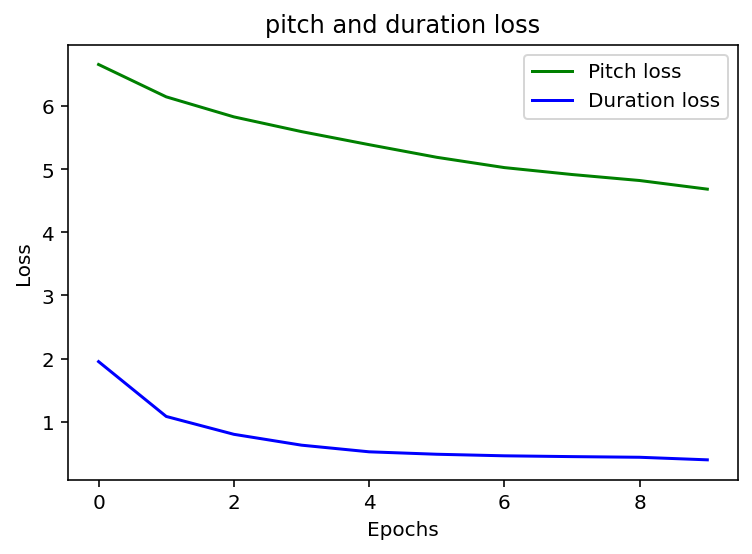

In [116]:
# https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib
pitch_loss = history.history['pitch_loss']
duration_loss = history.history['duration_loss']

# set 'epochs' according to the above result
epochs = 10
epochs = range(epochs)
plt.plot(epochs, pitch_loss, 'g', label='Pitch loss')
plt.plot(epochs, duration_loss, 'b', label='Duration loss')
plt.title('pitch and duration loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [118]:
def sample_with_temp(preds, temperature):

    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [119]:
# chord and duration sequences
initial_chords = np.expand_dims(train_chords[0,:].copy(), 0)
initial_durations = np.expand_dims(train_durations[0,:].copy(), 0)

In [120]:
initial_chords

array([[397, 398, 405,   0, 397, 398, 405,   0, 421, 421, 421, 451, 444,
         64,  24,  23, 422, 449,  48,  25,  26, 446, 452,  63, 546, 542,
        591, 601,  39,  22,  24, 286]])

In [121]:
initial_durations

array([[6, 2, 5, 5, 6, 2, 5, 5, 3, 3, 0, 1, 0, 5, 2, 2, 6, 2, 5, 2, 2, 6,
        2, 5, 2, 2, 6, 2, 5, 2, 2, 6]])

In [122]:
# Function to predict chords and durations
def predict_chords(chord_sequence, duration_sequence,model,temperature=1.0):
    predicted_chords, predicted_durations = model.predict([chord_sequence, duration_sequence])
    return sample_with_temp(predicted_chords[0],temperature), sample_with_temp(predicted_durations[0],temperature)

In [127]:
# Define empty lists for generated chords and durations
new_chords, new_durations = [], []

# Generate chords and durations using 120 rounds of prediction
for j in range(120):
    new_chord, new_duration = predict_chords(initial_chords, 
                                             initial_durations,
                                             model,
                                             temperature=0.8)
    new_chords.append(new_chord)
    new_durations.append(new_duration)
    initial_chords[0][:-1] = initial_chords[0][1:]
    initial_chords[0][-1] = new_chord
    initial_durations[0][:-1] = initial_durations[0][1:]
    initial_durations[0][-1] = new_duration

print("new_chords", new_chords)
print("new_durations", new_durations)

new_chords [243, 694, 694, 694, 704, 696, 624, 208, 694, 560, 694, 694, 571, 208, 694, 709, 709, 253, 247, 78, 85, 709, 705, 710, 694, 710, 694, 696, 247, 699, 694, 694, 208, 694, 208, 709, 694, 694, 694, 208, 694, 208, 694, 694, 694, 694, 694, 699, 253, 208, 794, 253, 709, 572, 715, 69, 694, 694, 704, 694, 208, 694, 208, 715, 694, 694, 694, 694, 694, 704, 615, 482, 694, 704, 696, 694, 833, 253, 253, 168, 344, 253, 343, 710, 709, 694, 572, 208, 694, 694, 694, 247, 227, 422, 235, 694, 694, 696, 699, 694, 710, 694, 857, 208, 694, 694, 698, 572, 694, 709, 706, 709, 208, 572, 709, 694, 694, 694, 694, 694]
new_durations [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 2, 2]


In [128]:
# Create stream object
generated_stream = stream.Stream()
generated_stream.append(instrument.Piano())

# Add notes and durations to stream
for j in range(len(new_chords)):
    try:
        generated_stream.append(note.Note(int_to_note[new_chords[j]].replace('.', ' '), 
                                          quarterType = int_to_duration[new_durations[j]]))
    except:
        generated_stream.append(chord.Chord(int_to_note[new_chords[j]].replace('.', ' '), 
                                            quarterType = int_to_duration[new_durations[j]]))

# Export as MIDI file
generated_stream.write('midi', fp='lstm_att_adam_5_midi_1.mid')

'lstm_att_adam_5_midi_1.mid'